## Regression Analysis on the Concrete Slump Test dataset

**Name: Elise Rattigan**<br>
**Last modified:** August 2021<br>

This project is adapted from one of the assignments in my Machine Learning unit at university, for which I received a mark of 100%.

The purpose of this project was to use regression analysis to explore the **Concrete Slump Test dataset** from *UCI Machine Learning*. This dataset has 103 instances, each with 7 input variables and 3 output variables. The goal for this project was to train two different regressors (a Decision Tree regressor and a Support Vector regressor) on the input variables, to try and predict the output variable, '28-day Compressive Strength (Mpa)'.

In this notebook, I will be using `GridSearch` cross-validation to find the best combination of hyperparameters, and then fitting the models to the training data. The models will be evaluated and compared using their MSE scores, and by plotting their predictions on a graph.

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# Training models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# For visualising decision trees
import graphviz
import pydotplus
import matplotlib.image as mpimg

## 1. Data Visualisation and Cleaning

The first step is to read in the data file and output a pandas DataFrame.

In [2]:
# Specify directory where data is located
data_dir = os.path.join('data', 'slump_test.data')

# Import data
slump = pd.read_csv(data_dir)

# Inspect first 5 lines of dataframe
slump.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [3]:
# Overview of the dataframe
slump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   No                                  103 non-null    int64  
 1   Cement                              103 non-null    float64
 2   Slag                                103 non-null    float64
 3   Fly ash                             103 non-null    float64
 4   Water                               103 non-null    float64
 5   SP                                  103 non-null    float64
 6   Coarse Aggr.                        103 non-null    float64
 7   Fine Aggr.                          103 non-null    float64
 8   SLUMP(cm)                           103 non-null    float64
 9   FLOW(cm)                            103 non-null    float64
 10  Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 9.0 KB

The above output shows there are 103 observations in the dataset, and it has 11 attributes. Of these 11 attributes:

* There are 7 input variables, `Cement`, `Slag`, `Fly ash`, `Water`, `SP`, `Coarse Aggr` and `Fine Aggr`, all numerical. These will be used as the predictor variables.
* There are 3 output variables. I will be using one of these, `Compressive Strength (28-day)(Mpa)`, as the target attribute. This is a numerical attribute.
* The remaining 2 output variables won't be used.

To look more closely at the data, we can visualise it as a correlation matrix. This is particularly useful for this dataset because the target attribute is numerical, so we can see how each of the predictors correlates with the target attribute. The below correlation matrix shows the correlations between the target and the 7 input variables.

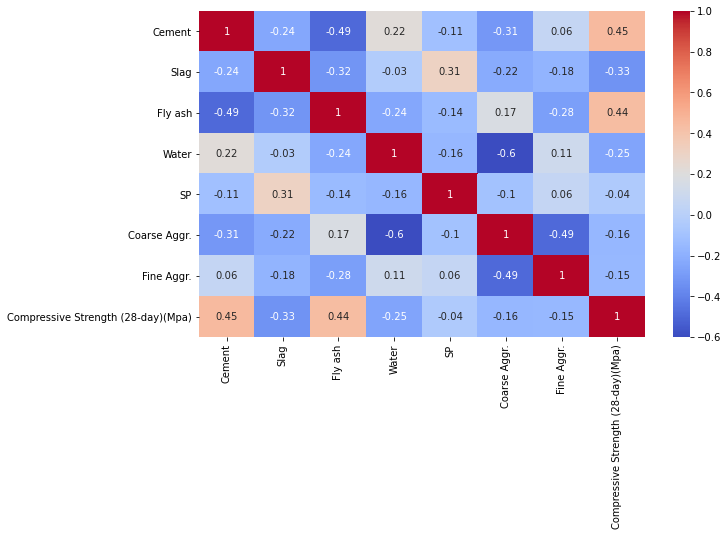

In [4]:
# Drop unnecessary columns from the dataframe
slump_new = slump.drop(['No', 'SLUMP(cm)', 'FLOW(cm)'], axis=1)

# Create correlation matrix
corr_matrix = slump_new.corr()
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm");

From the output above, we can see that none of the predictors are very highly correlated with the target variable. The highest is `Cement`, with a correlation of 0.45. Nor are the predictors very highly correlated with each other. The largest correlation is -0.49, between `Cement` and `Fly ash`, and also between `Fine Aggr` and `Coarse Aggr`.

Next, the data needs to be prepared before it can be used to train the regressor models. The function below accepts a dataframe and a target variable name as arguments, and separates the target variable from the rest of the columns (predictors). I will pass in the `slump_new` dataframe as an argument, which is the dataframe I created when I dropped unnecessary columns for the correlation matrix.

In [5]:
# Function to prepare data
def prepare_data(df, target): 
    # Separate target variable from the predictors
    X = df.drop(target, axis=1)
    y = df[target].values
    return X, y

In [6]:
# Apply function and assign to variables
X, y = prepare_data(slump_new, 'Compressive Strength (28-day)(Mpa)')

## 2. Data Preparation and Feature Scaling

### 2.1 Split the data

Using the prepared data, the next step is to implement two regressor models, a Decision Tree Regressor and a Support Vector regressor.

First, I will split the data into a training and test set, using the `train_test_split` function from Scikit-Learn with an 80/20 split.

In [13]:
# Random seed for reproducibility
np.random.seed(100)

# Split into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [14]:
print('There are {} instances in the training set.'.format(len(y_train)))

There are 82 instances in the training set.


In [15]:
print('There are {} instances in the test set.'.format(len(y_test)))

There are 21 instances in the test set.


### 2.2 Feature Scaling

To standardise the data in the training set, I will use Scikit-Learn's `StandardScaler` class on the numerical features. This will transform these features to have a mean of 0 and unit standard deviation.

In [16]:
# Create instance of StandardScaler class
scaler = StandardScaler()

# Transform the training data
X_train_scaled = scaler.fit_transform(X_train)

In [17]:
# Transform the test data with same transformation
X_test_scaled = scaler.transform(X_test)

## 3. Regressor Models

### 3.1 Decision Tree regressor

The first model I will train is the Decision Tree regressor.  For this regressor, I will use the hyperparameter `criterion=mse`, which means that at each split, the algorithm tries to choose the split which minimises the mean squared error.

I will use `GridSearchCV` with 3-fold cross-validation to find the best values for two more hyperparameters, which are:
* `max_depth`, which, as explained previously, specifies the maximum tree depth
* `min_impurity_decrease`, which is the minimum amount by which the impurity must decrease in order to split the node (default is 0)

I will investigate 3 different values for each of the hyperparameters.

The below function accepts the regressor, the grid of hyperparameters and the training data as arguments, performs grid search on these hyperparameters with 3-fold cross-validation, and returns the best combination of parameters as the final fitted model.

In [18]:
# Regressor training function
def train_regressor(regressor, X_train, y_train, params_grid):
    
    # Create regressor object
    reg_model = regressor()
    
    # Run GridSearchCV with grid of parameters, 3-fold cross-validation
    grid_search = GridSearchCV(reg_model, params_grid, cv=3)
    grid_search.fit(X_train, y_train)
    
    print('The best parameters are: {}'.format(grid_search.best_params_))
    
    return grid_search.best_estimator_

In [19]:
# Grid of parameters for the regressor on raw data
params_grid_reg = [{'criterion': ['mse'], 'max_depth': [2, 3, 4], 'min_impurity_decrease': [0, 0.1, 0.3]}]

In [21]:
# Apply function to raw data
reg_dt = train_regressor(DecisionTreeRegressor, X_train, y_train, params_grid_reg)

The best parameters are: {'criterion': 'mse', 'max_depth': 3, 'min_impurity_decrease': 0.1}


Applying the function to the training data with the Decision Tree regressor, the best model has been assigned to a variable and the best hyperparameters are shown in the output above. The results show that the best values are a `max_depth` of 3 and a `min_impurity_decrease` of 0 (although I would note that I ran this code a few times, and on some occasions, these values were different, due to variance in the cross-validation).

Below is another function which uses the final model to make predictions, and performs cross-validation with 3-folds to get the mean squared error on the predictions.

In [24]:
from sklearn.model_selection import cross_val_score

# Function to get MSE of predictions
def mse_pred(best_model, X_test, y_test):
    # Use the final model to make predictions on the test set
    y_pred = best_model.predict(X_test)
    
    # Cross-validation with 3-folds to get MSE
    scores = cross_val_score(best_model, X_test, y_test, cv=3, scoring='neg_mean_squared_error')
    print("MSE scores:", -scores)
    print("Average MSE score:", -scores.mean())
    return y_pred, -scores

In [25]:
# Apply function to best raw regressor
reg_dt_pred, reg_dt_scores = mse_pred(reg_dt, X_test, y_test)

MSE scores: [118.61731746 138.50155873 179.97507143]
Average MSE score: 145.69798253968253


The average mean squared error of this model (across all three folds) is 151.14. Again, due to variance in the cross-validation process, I got a different score on a couple of occasions of running the code, so I note that output may change if this code is run again.

This is a fairly small value of MSE, suggesting the model has performed quite well.

### 3.2 Support Vector Regressor

Secondly, I will train the Support Vector regressor on the training data. For this model, I will use the `SVR` class from Scikit-Learn because it supports the use of kernels (while the `LinearSVR` class does not).

For this model, I will use `GridSearch` to explore three different values of the following three hyperparameters:

* `kernel`, which specifies the type of kernel
* `C`, which is the regularisation parameter. A smaller value of C means more regularisation
* `gamma`, which is the parameter for RBF and poly kernels. It controls the range of influence of each instance. A small gamma means the instances have a larger range of influence, leading to a smoother decision boundary.

In [26]:
# Grid of parameters for the SVR
params_grid_svr = [{'kernel': ['linear', 'poly', 'rbf'], 'C': [1, 100, 1000], 'gamma': [0.001, 0.01, 0.1]}]

In [27]:
# Apply training function to SVR
svr = train_regressor(SVR, X_train_scaled, y_train, params_grid_svr)

The best parameters are: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


The results from the grid search show that the best hyperparameter values are the RBF kernel, **C** = 1000 and $\gamma$ = 0.01.  This large value of C means less regularisation, which could cause overfitting. The $\gamma$ parameter is quite small, meaning a larger range of influence and a smoother decision boundary.

Next, I will apply the function to get the mean squared error of the predictions.

In [28]:
# Get MSE of best SVR
svr_pred, svr_scores = mse_pred(svr, X_test_scaled, y_test)

MSE scores: [ 5.38960314  4.74546169 10.02638535]
Average MSE score: 6.720483395707842


The average mean squared error of this model (across all three folds) is 6.72. This is a very small score, much smaller than the MSE score of the Decision Tree regressor, implying that this SVR model has performed much better.

## 4. Outputs and comparison

We can now compare and evaluate the performance of the two models.

In [29]:
# Show table of average MSE
mse_values = [[reg_dt_scores.mean(), svr_scores.mean()]]
mse_headers = ['DT regressor', 'SV regressor']

mse_df = pd.DataFrame(mse_values, index=None, columns=mse_headers)
mse_df

,DT regressor,SV regressor
0,145.697983,6.720483


The mean squared error (MSE) is a measure of the difference between the true and predicted values. The smaller the value, the closer the predictions are to the truth.

Looking at the above table, the MSE score for the SV regressor is much smaller than for the DT regressor, and is actually very close to zero. This suggests that the SV regressor has performed the best out of the two, and is a near-perfect model.

We can visualise the performance of each regressor by plotting the prediction results. The code below outputs a plot with 3 subplots, which are explained further down.

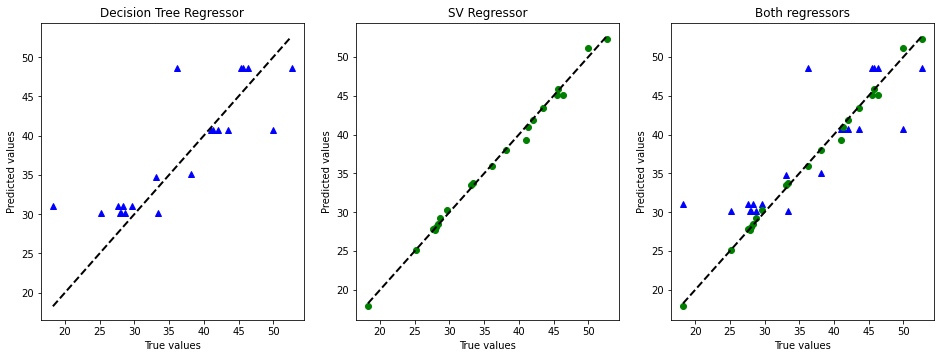

In [39]:
# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))

# Plot the data
ax1.plot(y_test, reg_dt_pred, 'b^')
ax2.plot(y_test, svr_pred, 'go')
ax3.plot(y_test, reg_dt_pred, 'b^')
ax3.plot(y_test, svr_pred, 'go')

# Add line for true values
for ax in fig.get_axes():
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Add titles and axis labels
title_list = ['Decision Tree Regressor', 'SV Regressor', 'Both regressors']
for i in np.arange(0, 3):
    axis = fig.get_axes()[i]
    axis.set(title=title_list[i], xlabel='True values', ylabel='Predicted values');

# Adjust spacing
plt.subplots_adjust(top=1.5)

The first two subplots show the two regressors separately. They show the true values (y_test) against the predicted results from the regressor. The black line going through the graph joins the minimum and maximum values of y-test, and is an indicator of how close the predicted values are to the true values. The closer to this line, the closer the predicted values are to the truth.

The third subplot (far right) shows the same values, but plots both regressors on the same graph.

It is clear from the plots that the Support Vector regressor had the best performance. This is supported by its low MSE score. All the points on the SV regressor graph are very close to the line, showing that the predicted values were all very close to the truth.